In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pystan
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)
%matplotlib inline

In [2]:
df=pd.read_csv("q_data_x.csv")

In [3]:
df["TVwatch_day"]=df["TVwatch_day"]/10000
df["gamesecond"]=(df["gamesecond"]/100).astype(int)

In [4]:
X=df[['cm_dummy','T','F1', 'F2', 'F3', 'M1', 'M2', 'M3', 'TVwatch_day',"child_dummy"]]

In [9]:
model="""
functions {
  real ZIP_lpmf(int Y, real q, real lambda) {
    if (Y == 0) {
      return log_sum_exp(
        bernoulli_lpmf(0 | q),
        bernoulli_lpmf(1 | q) + poisson_log_lpmf(0 | lambda)
      );
    } else {
      return bernoulli_lpmf(1 | q) + poisson_log_lpmf(Y | lambda);
    }
  }
}

data {
  int N;
  int D;
  int<lower=0> Y[N];
  matrix[N,D] X;
}

parameters {
  vector[D] b[2];
}

transformed parameters {
  vector[N] q_x;
  vector[N] q;
  vector[N] lambda;

  q_x = X*b[1];
  lambda = X*b[2];
  for (n in 1:N)
    q[n] = inv_logit(q_x[n]);
}

model {
  for (n in 1:N)
    Y[n] ~ ZIP(q[n], lambda[n]);
}
"""

In [10]:
data={'N': X.shape[0], 'D':X.shape[1] ,'Y':df["gamesecond"].values, 'X':np.array(X)}

In [11]:
%time fit = pystan.stan(model_code=model, data=data, iter=1000, chains=3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5a7a10f9948c1c422c1ef9c8de84f6de NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 3.25 s, sys: 15.3 s, total: 18.6 s
Wall time: 5min 19s


In [12]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_5a7a10f9948c1c422c1ef9c8de84f6de.
3 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[1,1]    0.17  2.2e-3   0.08   0.01   0.11   0.17   0.23   0.34   1465   1.01
b[2,1]   -0.26  7.8e-5 4.0e-3  -0.27  -0.27  -0.26  -0.26  -0.26   2684    1.0
b[1,2]   -1.88  5.2e-3   0.25  -2.38  -2.04  -1.88  -1.71  -1.41   2315    1.0
b[2,2]    5.96  2.1e-4   0.01   5.94   5.96   5.96   5.97   5.99   2914    1.0
b[1,3]   -2.97  3.7e-3   0.14  -3.26  -3.06  -2.96  -2.87  -2.71   1438    1.0
b[2,3]    5.33  1.7e-4 9.3e-3   5.31   5.33   5.33   5.34   5.35   2843    1.0
b[1,4]   -2.94  3.8e-3   0.12  -3.21  -3.02  -2.94  -2.86  -2.71   1079    1.0
b[2,4]    6.03  1.4e-4 6.5e-3   6.02   6.02   6.03   6.03   6.04   2133    1.0
b[1,5]   -2.91  5.4e-3   0.21  -3.32  -3.05  -2.91  -2.77  -2.

In [13]:
# サンプル列を抽出
la  = fit.extract(permuted=True)

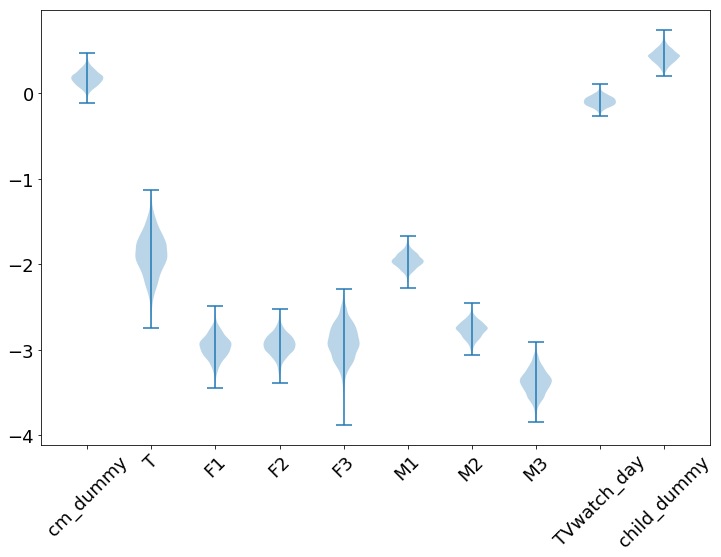

In [14]:
#ゲームプレイ有無への寄与度
plt.figure(figsize=(12,8))
plt.violinplot([la["b"][:,0,i] for i in range(10)])
plt.xticks(list(range(1,len(X.columns)+1)), X.columns)
plt.xticks(rotation=45)
plt.tick_params(labelsize=18)
plt.show()

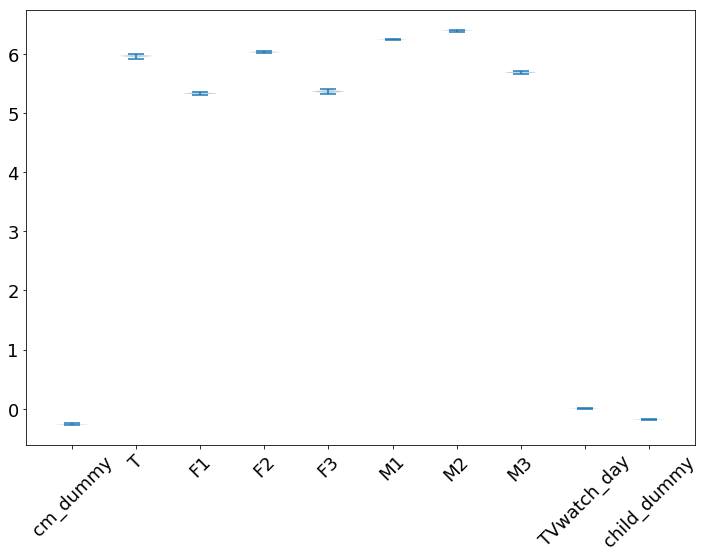

In [15]:
#ゲームプレイ時間への寄与度
plt.figure(figsize=(12,8))
plt.violinplot([la["b"][:,1,i] for i in range(10)])
plt.xticks(list(range(1,len(X.columns)+1)), X.columns)
plt.xticks(rotation=45)
plt.tick_params(labelsize=18)
plt.show()